In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# process columns, apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [4]:
##Add decomposed components: PCA / ICA etc.
from sklearn.decomposition import PCA, FastICA
n_comp = 10

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]
    
y_train = train["y"]
y_mean = np.mean(y_train)

In [5]:
### Regressor
import xgboost as xgb

# prepare dict of params for xgboost to run with
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}


# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(train.drop('y', axis=1), y_train)
dtest = xgb.DMatrix(test)

/home/amin/Software/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0]	train-rmse:12.6399	test-rmse:12.6383
[100]	train-rmse:10.0181	test-rmse:10.1468
[200]	train-rmse:8.80275	test-rmse:9.06668
[300]	train-rmse:8.26051	test-rmse:8.63724
[400]	train-rmse:7.94862	test-rmse:8.47724
[500]	train-rmse:7.7256	test-rmse:8.42322
[600]	train-rmse:7.5545	test-rmse:8.40571
[700]	train-rmse:7.41281	test-rmse:8.40457
673


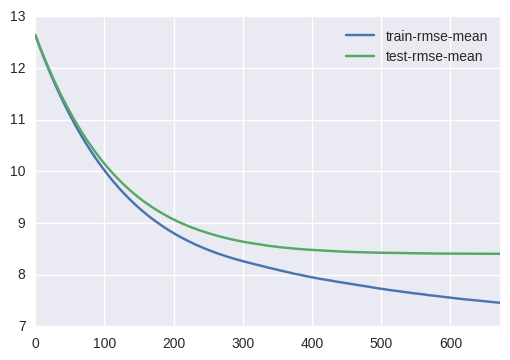

In [12]:
# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=800, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=100, 
                   show_stdv=False
                  )
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

In [13]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

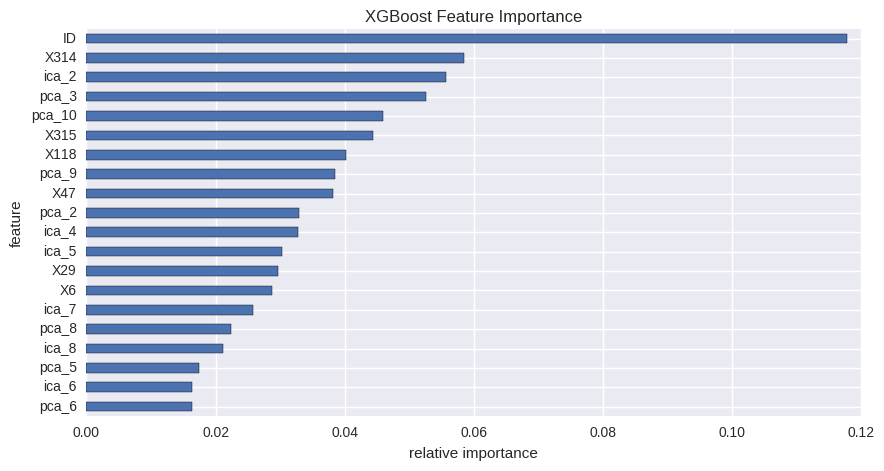

In [21]:
import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [20]:
# make predictions and save results
y_pred = model.predict(dtest)

output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('submission_baseLine.csv', index=False)

In [39]:
from sklearn.metrics import r2_score
def xgb_r2(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', -r2_score(labels, preds)

xgb_r2(model.predict(dtrain), dtrain)

('r2', -0.63394500994203129)

In [41]:
# prepare dict of params for xgboost to run with
xgb_params = {
    'eta': 0.005,
    'max_depth': 4,
    'objective': 'reg:linear'
}

cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=2000, # increase to have better results (~700)
                   early_stopping_rounds=20,
                   feval=xgb_r2,
                   verbose_eval=100, 
                   nfold=5,
                   show_stdv=False
                  )

[0]	train-r2:61.7958	test-r2:62.312
[100]	train-r2:22.3533	test-r2:22.5416
[200]	train-r2:7.85749	test-r2:7.927
[300]	train-r2:2.52602	test-r2:2.55658
[400]	train-r2:0.553893	test-r2:0.582599
[500]	train-r2:-0.182035	test-r2:-0.145065
[600]	train-r2:-0.457858	test-r2:-0.412781
[700]	train-r2:-0.565896	test-r2:-0.51164
[800]	train-r2:-0.612297	test-r2:-0.547532
[900]	train-r2:-0.634256	test-r2:-0.560133
[1000]	train-r2:-0.646471	test-r2:-0.564165
[1100]	train-r2:-0.654997	test-r2:-0.56485


1095


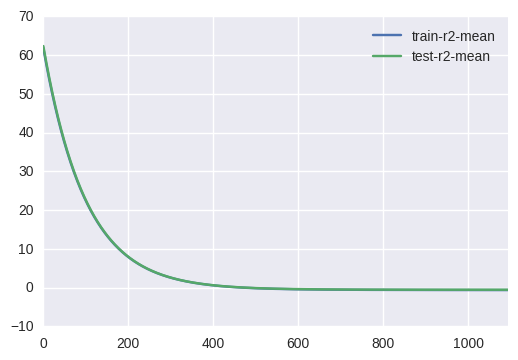

In [42]:
cv_result[['train-r2-mean', 'test-r2-mean']].plot()

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

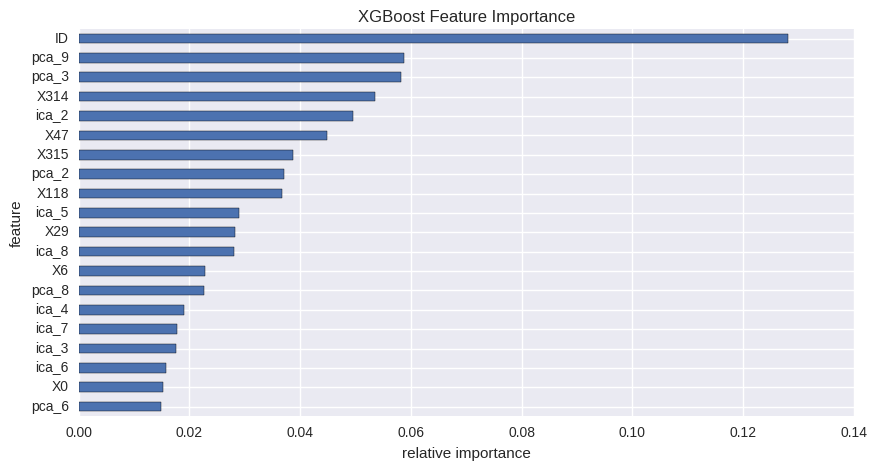

In [44]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [45]:
xgb_r2(model.predict(dtrain), dtrain)

('r2', -0.64296267089891612)

In [46]:
# make predictions and save results
y_pred = model.predict(dtest)

output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('submission_baseLine_r2.csv', index=False)